<a href="https://colab.research.google.com/github/JoseFPortoles/U-Net-Xception_in-Keras/blob/master/U_Net_Cityscapes_car_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car segmentation with the Cityscapes dataset
[Cityscapes](https://www.cityscapes-dataset.com/) [1] is a dataset for semantic understanding of urban scenes. Among other data it contains 5000 color images with their corresponding finely  pixel-wise annotated ground-truth masks. The masks annotate 30 different categories of urban scenery objects including different types of vehicles, people and urban constructions among others.

The following is a simple attempt at training a deep learning model for semantic segmentation of a single category, namely cars, but it is easily adaptable to other categories (by changing the value of a single variable).

The neural architecture employed for this example, a U-Net-Xception style CNN, is adapted from the [keras blog](https://keras.io/examples/vision/oxford_pets_image_segmentation/) [2] with minimal changes.


## Set variables

In [ ]:
#Variables
x_imsize = 160
y_imsize = 160
img_size = (x_imsize,y_imsize)
num_classes = 2
batch_size = 32
epochs = 100

## Build model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

## Load a model
Uncomment and use instead of the model building cell if you want to load a pretrained model.

In [ ]:
#from tensorflow import keras

#model_path ='/content/U-Net-Xception_Segmentation.h5'
#model = keras.models.load_model(model_path)

## Gather file paths 
The dataset keeps images and ground thruth masks separated in different folders, each containing subfolders for the training and the validation sets which in turn contain subfolders for the different cities. For the purpose of this example we don't care about distinction between cities, so the following script scans every subdirectory gathering a list of paths for all the different images and masks and returning four list, namely training and validation sets of images and the corresponding masks.

In [ ]:
import os

dir_msk = '/content/gtFine'
dir_img = '/content/leftImg8bit'

def gatherPaths(dir_img, dir_msk):
    """ Recursively gather mask files under path dir_msk.
    Then build list of corresponding image paths in the same
    order."""
    msk_files = []
    img_files = []
    for i, r in enumerate(os.walk(dir_msk)):
        if i==0:
            towns = r[1]
        else:
            town = towns[i-1]
            files = r[2]
            for file in files:
                if 'labelIds' in file:
                    msk_files.append(
                        os.path.join(
                            dir_msk,
                            town,
                            file
                        )
                    )
                    img_files.append(
                        os.path.join(
                            dir_img,
                            town,
                            file.split('_gtFine_')[0]
                        ) 
                        + '_leftImg8bit.png'
                    )
    return img_files, msk_files

dir_img_train = os.path.join(dir_img, 'train')
dir_msk_train = os.path.join(dir_msk, 'train')

input_train_paths, target_train_paths = gatherPaths(dir_img_train, dir_msk_train) 

dir_img_val = os.path.join(dir_img, 'val')
dir_msk_val = os.path.join(dir_msk, 'val')

input_val_paths, target_val_paths = gatherPaths(dir_img_val, dir_msk_val) 



## Data generation
This cell builds data generators through the Keras Sequence class. The method \_\_getitem()\_\_ returns a batch of images with its corresponding batch of ground truth masks.

The masks for this example are produced by binarising the original Cityscapes finely annotated ground truth masks down to only two categories, namely cars (pixel=1) and background (pixel=0).

No data augmentation is applied by the current code, although it could be easily implemented with a dedicated library such as [Imgaug](https://imgaug.readthedocs.io/en/latest/) 

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import PIL

class CityScapesSegData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, num_classes, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.img_size = img_size
        self.mask_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) corresponding to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, (path_img, path_msk) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
            img = load_img(path_img, target_size=self.img_size)
            x[j] = img
            msk = load_img(path_msk, target_size=self.mask_size, color_mode="grayscale")
            msk = np.expand_dims(msk, 2)
            y[j] = msk.astype('uint8')
        #Convert target masks to binary masks (1: Car, 0: Background)
        y = np.where(y==26, 1, 0)
        return x, y


# Instantiate data generators for each split

train_gen = CityScapesSegData(
    batch_size,
    num_classes,
    img_size,
    input_train_paths, 
    target_train_paths, 
)

val_gen = CityScapesSegData(
    batch_size, 
    num_classes, 
    img_size, 
    input_val_paths, 
    target_val_paths, 
)

## Train the model

In [ ]:
# Compile model for training
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import CategoricalCrossentropy
import numpy as np

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-5, momentum = 0.9), 
    loss="sparse_categorical_crossentropy", 
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/U-Net-Xception_Segmentation.h5",
        monitor = 'val_loss',
        save_best_only=True,
        ),
    #keras.callbacks.EarlyStopping(
    #    monitor = 'val_loss',
    #   patience = 50,
    #)
]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

## Visualise predictions on a few example images
The following cell tests the model by predicting segmentation masks from a number of test pictures gathered from the test subset.

On each row the image is presented next to a representation in two colors of the predicted masks and the superposition of mask and picture.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


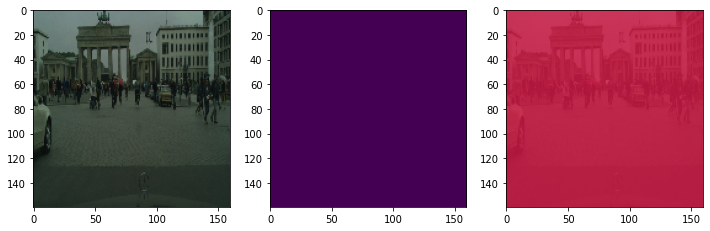

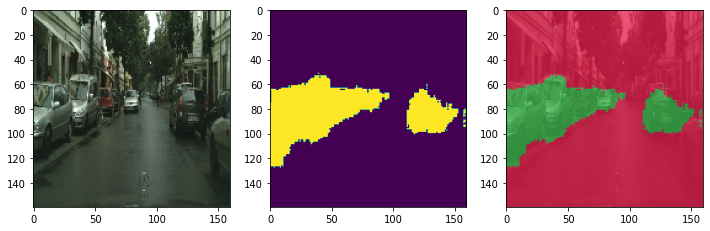

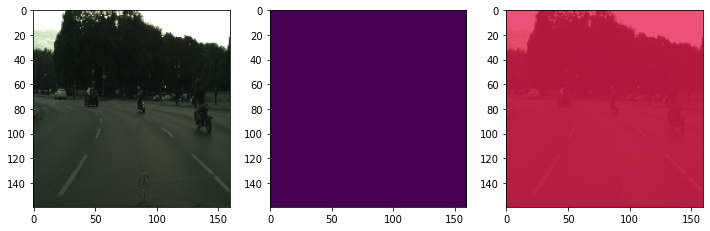

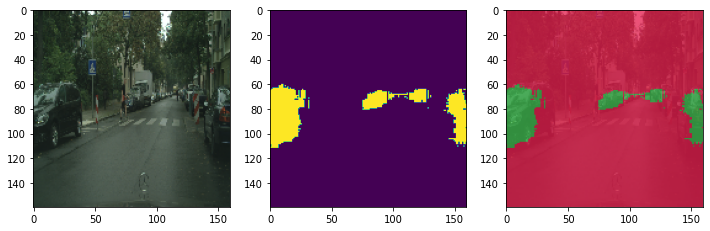

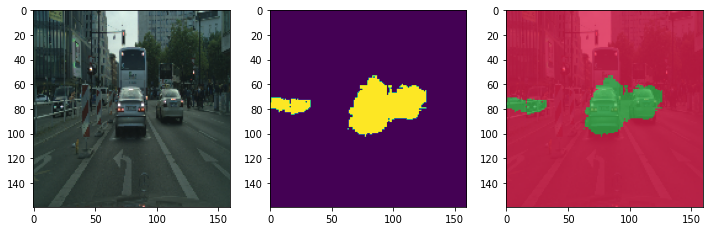

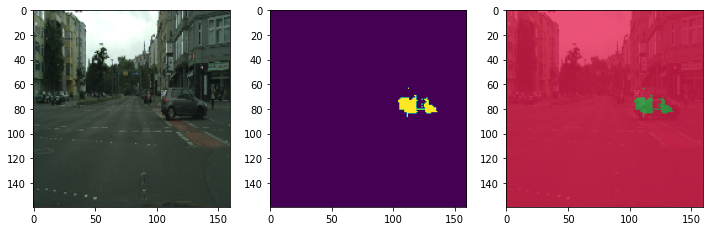

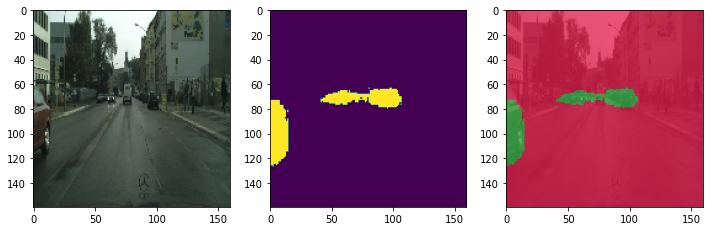

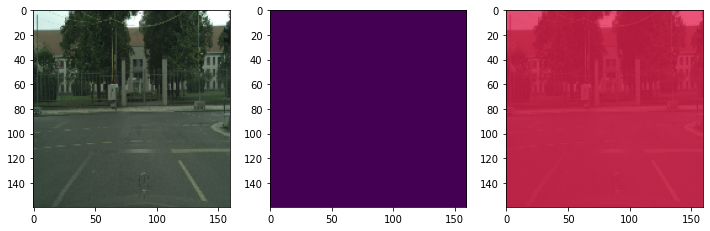

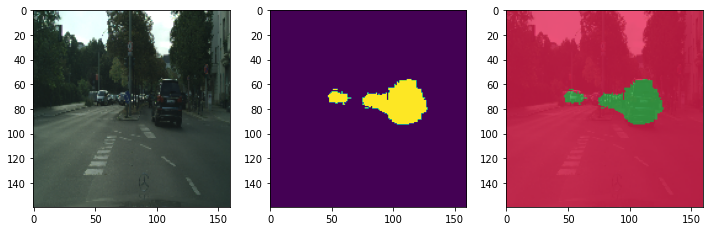

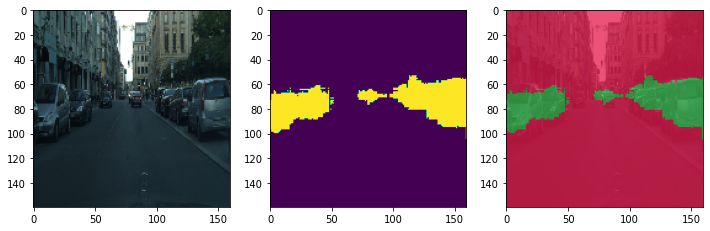

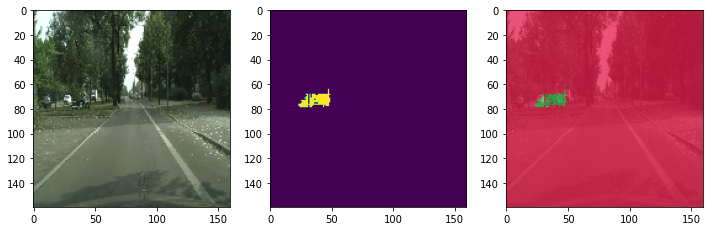

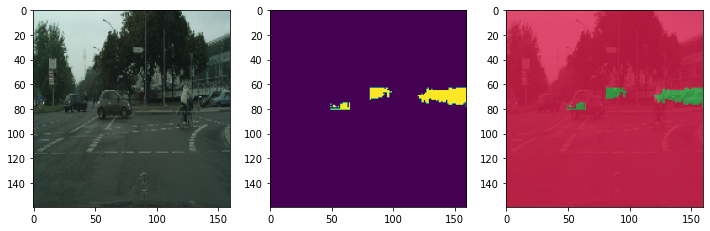

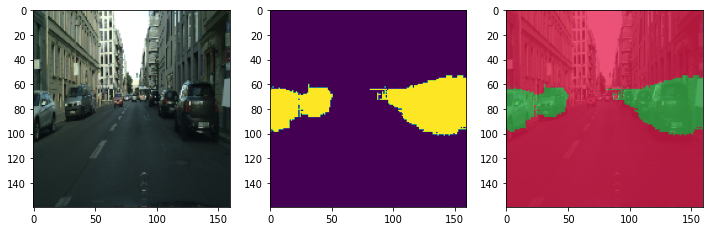

In [ ]:
import matplotlib.pyplot as plt
from imgaug import SegmentationMapOnImage

test_dir = '/content/leftImg8bit/test/berlin/'
jpg_pathlist = os.listdir(test_dir)
jpg_pathlist = [os.path.join(test_dir,x) for x in jpg_pathlist if '.jpg' in x or '.jpeg' in x or '.png' in x]

def showImgMsk(path, model):
  img = load_img(path, target_size = (160,160), color_mode='rgb')
  img = img_to_array(img, data_format='channels_last' ).astype('uint8')
  plt.figure(figsize=(12,36))
  plt.subplot(131)
  plt.imshow(img)
  img_batch = np.expand_dims(img, axis=0)
  pred_categorical = model.predict(img_batch)
  pred = np.argmax(pred_categorical, axis=3)
  plt.subplot(132)
  plt.imshow(pred[0])
  segmap = SegmentationMapOnImage(pred_categorical[0], shape=img.shape)
  segmap = segmap.draw_on_image(img)
  plt.subplot(133)
  plt.imshow(segmap)

for path in jpg_pathlist:
  showImgMsk(path,model)

## Citations

[1] M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, “The Cityscapes Dataset for Semantic Urban Scene Understanding,” in Proc. of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016.

[2] François Chollet, "Image segmentation with a U-Net-like architecture". The Keras Blog, Code Examples ([Link](https://keras.io/examples/vision/oxford_pets_image_segmentation/)).